In [1]:
# !pip install pandas --quiet
# !pip install matplotlib --quiet
# !pip install scikit-learn --quiet
# !pip install seaborn --quiet
# !pip install tqdm --quiet
# !pip install tensorflow==2.14.0 --quiet
# !pip install tensorflow-addons --quiet

In [1]:
import tensorflow_addons as tfa



import numpy as np
import pandas as pd


import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

C:\Users\prano\.conda\envs\condaenvlatest\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [61]:
# datasetpar = pd.read_parquet('/Users/hetpatel/Downloads/asl-signs/train_landmark_files/2044/3127189.parquet')
# datasetpar.to_csv('my_data1.csv', index=True)

In [2]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install pyarrow fastparquet
!pip install pydot



Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


# Plot Config

In [2]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Config

In [3]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = True
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = False

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
IS_INTERACTIVE = 'Interactive'
VERBOSE = 1 if IS_INTERACTIVE else 2

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 110
LR_MAX = 1e-3 #learning rate 10^-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

# Utils

In [4]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')


# Train

**Checking Info of CSV File**

In [5]:
csv_data = pd.read_csv('train.csv')

In [6]:
# Read Training Data

if IS_INTERACTIVE or not PREPROCESS_DATA:
    train = pd.read_csv('train.csv').sample(int(5e3), random_state=SEED)
else:
    train = pd.read_csv('train.csv')

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 5000


# Add File Path

In [7]:
# Get complete file path to file
def get_file_path(path):
    return f'D:/Study/College/MInor Project/asl-signs/{path}'  

train['file_path'] = train['path'].apply(get_file_path)

#adding another column to the train dataframe called file_path where it contains absolute path of the info
print(train.head(2))

                                                path  participant_id  \
56533  train_landmark_files/28656/3311214787.parquet           28656   
63119  train_landmark_files/53618/3588192588.parquet           53618   

       sequence_id    sign                                          file_path  
56533   3311214787  sticky  D:/Study/College/MInor Project/asl-signs/train...  
63119   3588192588  before  D:/Study/College/MInor Project/asl-signs/train...  


# Ordinally Encode Sign

In [8]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes
# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()

ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

#dataframe after encoding sign with number as a column named sign_ord
print(train.head(2))

                                                path  participant_id  \
56533  train_landmark_files/28656/3311214787.parquet           28656   
63119  train_landmark_files/53618/3588192588.parquet           53618   

       sequence_id    sign                                          file_path  \
56533   3311214787  sticky  D:/Study/College/MInor Project/asl-signs/train...   
63119   3588192588  before  D:/Study/College/MInor Project/asl-signs/train...   

       sign_ord  
56533       206  
63119        20  


In [9]:
display(train.head(30))
display(train.info())
df1 = pd.DataFrame(train)

df1.to_csv('datas.csv', index=False)

,path,participant_id,sequence_id,sign,file_path,sign_ord
56533,train_landmark_files/28656/3311214787.parquet,28656,3311214787,sticky,D:/Study/College/MInor Project/asl-signs/train...,206
63119,train_landmark_files/53618/3588192588.parquet,53618,3588192588,before,D:/Study/College/MInor Project/asl-signs/train...,20
8760,train_landmark_files/4718/1363575346.parquet,4718,1363575346,pretty,D:/Study/College/MInor Project/asl-signs/train...,178
93310,train_landmark_files/37779/951199059.parquet,37779,951199059,hen,D:/Study/College/MInor Project/asl-signs/train...,114
44842,train_landmark_files/36257/283190141.parquet,36257,283190141,tomorrow,D:/Study/College/MInor Project/asl-signs/train...,221
20993,train_landmark_files/61333/186594661.parquet,61333,186594661,up,D:/Study/College/MInor Project/asl-signs/train...,230
89267,train_landmark_files/53618/782770724.parquet,53618,782770724,blow,D:/Study/College/MInor Project/asl-signs/train...,25
48370,train_landmark_files/16069/2977903115.parquet,16069,2977903115,weus,D:/Study/College/MInor Project/asl-signs/train...,236
41330,train_landmark_files/2044/269101282.parquet,2044,269101282,read,D:/Study/College/MInor Project/asl-signs/train...,184
53090,train_landmark_files/28656/3171133897.parquet,28656,3171133897,say,D:/Study/College/MInor Project/asl-signs/train...,191


<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 56533 to 19516
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            5000 non-null   object
 1   participant_id  5000 non-null   int64 
 2   sequence_id     5000 non-null   int64 
 3   sign            5000 non-null   object
 4   file_path       5000 non-null   object
 5   sign_ord        5000 non-null   int16 
dtypes: int16(1), int64(2), object(3)
memory usage: 244.1+ KB


None

In [10]:
# par =pd.read_parquet('asl-signs/train_landmark_files/2044/1001950812.parquet')

# Video Statistics

In [9]:
'''UNDER REVIEW'''
N = int(1e3) if (IS_INTERACTIVE or not PREPROCESS_DATA) else int(10e3)
print(N)
N_UNIQUE_FRAMES = np.zeros(N, dtype=np.uint16)
N_MISSING_FRAMES = np.zeros(N, dtype=np.uint16)
MAX_FRAME = np.zeros(N, dtype=np.uint16)

PERCENTILES = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

for idx, file_path in enumerate(tqdm(train['file_path'].sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    N_UNIQUE_FRAMES[idx] = df['frame'].nunique()
    N_MISSING_FRAMES[idx] = (df['frame'].max() - df['frame'].min()) - df['frame'].nunique() + 1
    MAX_FRAME[idx] = df['frame'].max()
print(N_UNIQUE_FRAMES[0],N_MISSING_FRAMES[0],MAX_FRAME[0])

1000


  0%|          | 0/1000 [00:00<?, ?it/s]

41 0 40


In [ ]:
# Number of unique frames in each video
'''UNDER REVIEW'''
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_UNIQUE_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+25, 25))
plt.show()

,N_MISSING_FRAMES
count,1000.000000
mean,0.001000
std,0.031623
min,0.000000
1%,0.000000
5%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
95%,0.000000


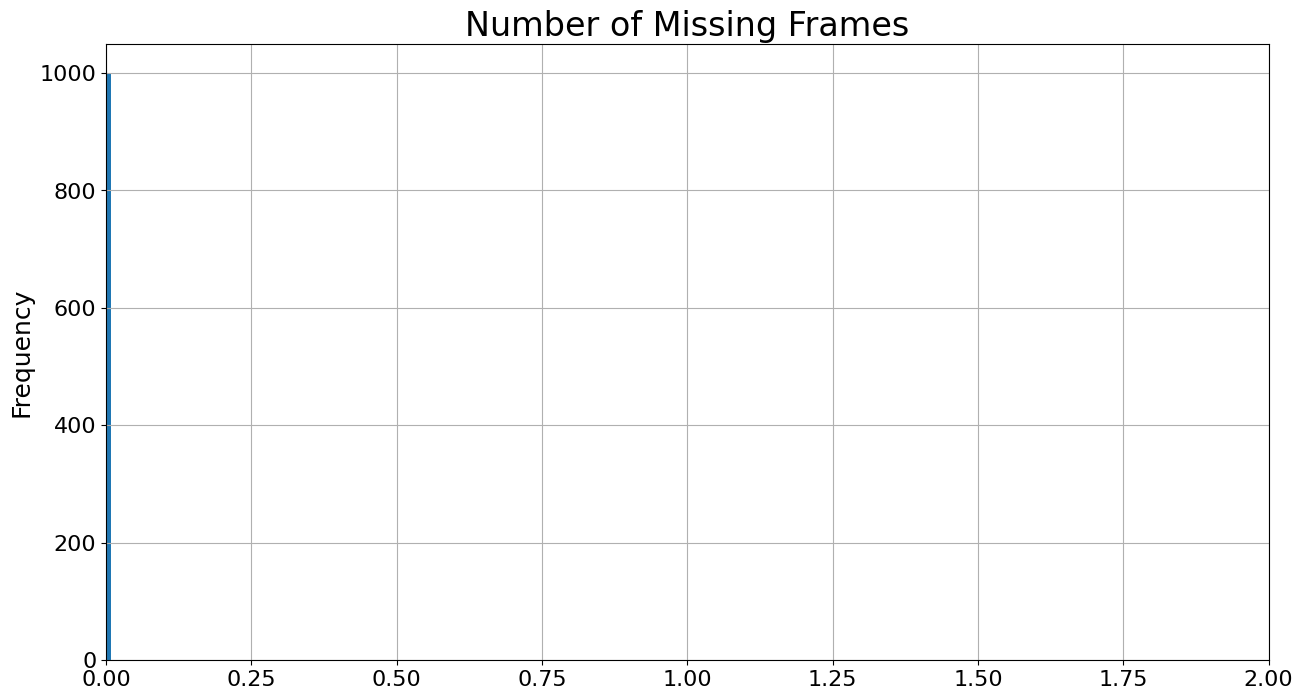

In [46]:
# Number of missing frames, consecutive frames with missing intermediate frame, i.e. 1,2,4,5 -> 3 is missing
display(pd.Series(N_MISSING_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_MISSING_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Missing Frames', size=24)
pd.Series(N_MISSING_FRAMES).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

,MAX_FRAME
count,1000.000000
mean,66.761000
std,59.679222
min,3.000000
1%,12.990000
5%,22.000000
25%,33.000000
50%,42.000000
75%,61.000000
95%,203.050000


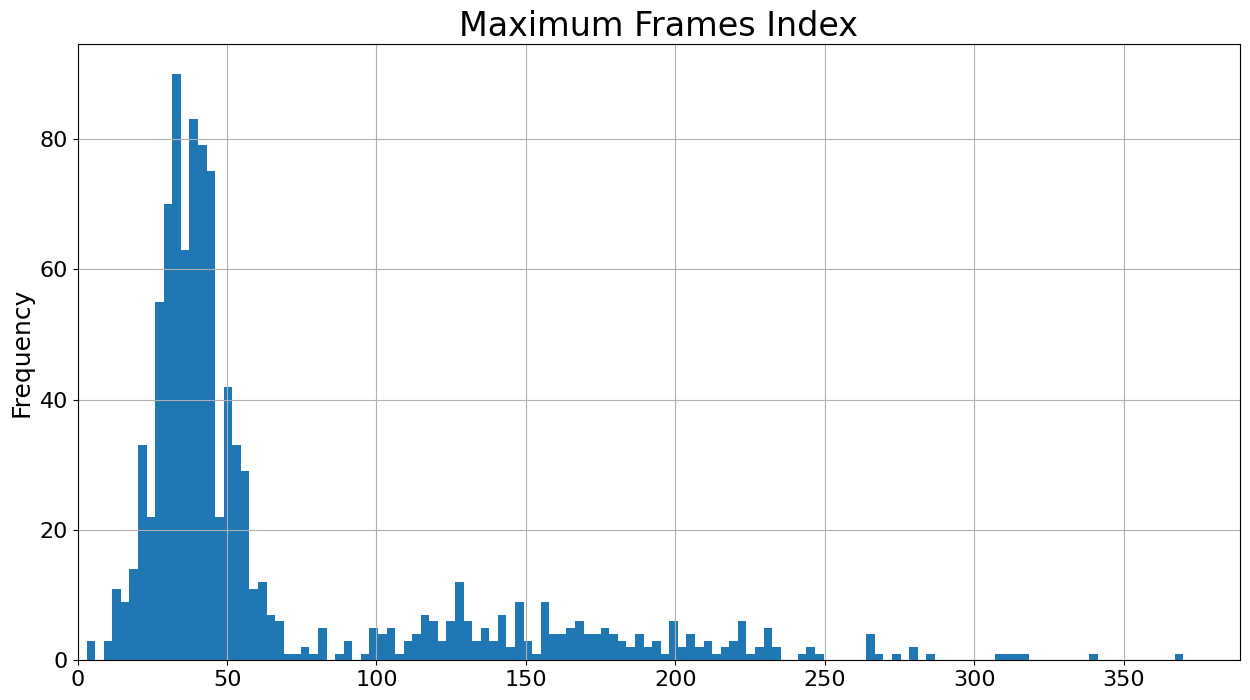

In [47]:
# Maximum frame number
display(pd.Series(MAX_FRAME).describe(percentiles=PERCENTILES).to_frame('MAX_FRAME'))

plt.figure(figsize=(15,8))
plt.title('Maximum Frames Index', size=24)
pd.Series(MAX_FRAME).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

# Landmark Indices


In [10]:
'''USE IN TEST RESULTS'''
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [11]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


# Process Data Tensorflow

In [12]:

ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):

    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [13]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
"""
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])

    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)

    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]

        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum

        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )

        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)

        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)

        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]

        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )

        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)

            return data, non_empty_frames_idxs

preprocess_layer = PreprocessLayer()

# Interpolate NaN Values

In [14]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544

"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    return data

# Create Dataset

In [15]:
# Get the full dataset
def preprocess_data():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        # Log message every 5000 samples
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)

    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
    PARTICIPANT_IDS = train['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    
    X_train = X[train_idxs]
    yz = X_train
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)
    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')
# preprocess_data()


In [16]:
# Preprocess All Data From Scratch
if PREPROCESS_DATA:
    preprocess_data()
    ROOT_DIR = ''
else:
    ROOT_DIR = ''

# Load Data
if USE_VAL:
    # Load Train
    X_train = np.load(f'X_train.npy')
    y_train = np.load(f'y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'X_val.npy')
    y_val = np.load(f'y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'X.npy')
    y_train = np.load(f'y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Train
print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Generated 0/5000
Patient ID Intersection Train/Val: set()
X_train shape: (4243, 64, 66, 3), X_val shape: (757, 64, 66, 3)
y_train shape: (4243,), y_val shape: (757,)
X_train shape: (5000, 64, 66, 3), dtype: float32
y_train shape: (5000,), dtype: int32
NON_EMPTY_FRAME_IDXS_TRAIN shape: (5000, 64), dtype: float32
# NaN Values X_train: 0


In [17]:
# Class Count
display(pd.Series(y_train).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

,Class Count
245,37
173,36
177,35
208,31
46,31
203,11
107,10
161,10
196,10
237,9


# Number Of Frames

  0%|          | 0/64 [00:00<?, ?it/s]

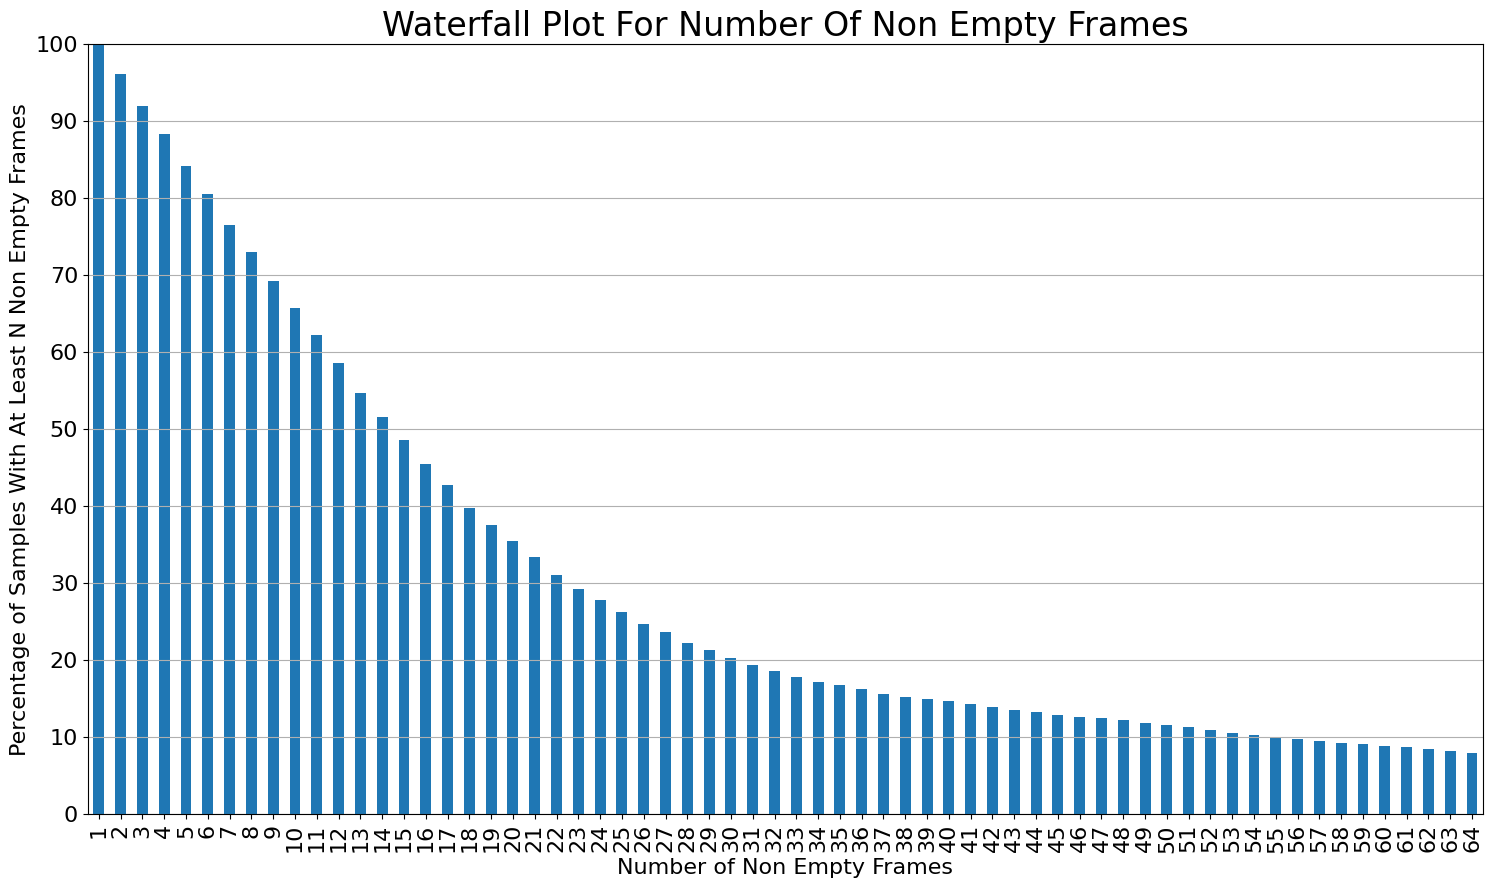

In [18]:
# Vast majority of samples fits has less than 32 non empty frames
N_EMPTY_FRAMES = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum(axis=1)
N_EMPTY_FRAMES_WATERFALL = []
for n in tqdm(range(1,INPUT_SIZE+1)):
    N_EMPTY_FRAMES_WATERFALL.append(sum(N_EMPTY_FRAMES >= n) / len(NON_EMPTY_FRAME_IDXS_TRAIN) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Non Empty Frames')
pd.Series(N_EMPTY_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks(np.arange(INPUT_SIZE), np.arange(1, INPUT_SIZE+1))
plt.xlabel('Number of Non Empty Frames', size=16)
plt.yticks(np.arange(0, 100+10, 10))
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Non Empty Frames', size=16)
plt.show()

# Percentage of Frames Filled

In [19]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
print(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

P_DATA_FILLED: 31.11%


# Feature Statistics - Lips

In [20]:
# Percentage of Lips Measurements
P_LEFT_LIPS_MEASUREMENTS = (X_train[:,:,LIPS_IDXS] != 0).sum() / X_train[:,:,LIPS_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_LIPS_MEASUREMENTS: {P_LEFT_LIPS_MEASUREMENTS:.2f}%')

P_LEFT_LIPS_MEASUREMENTS: 99.36%


  0%|          | 0/40 [00:00<?, ?it/s]

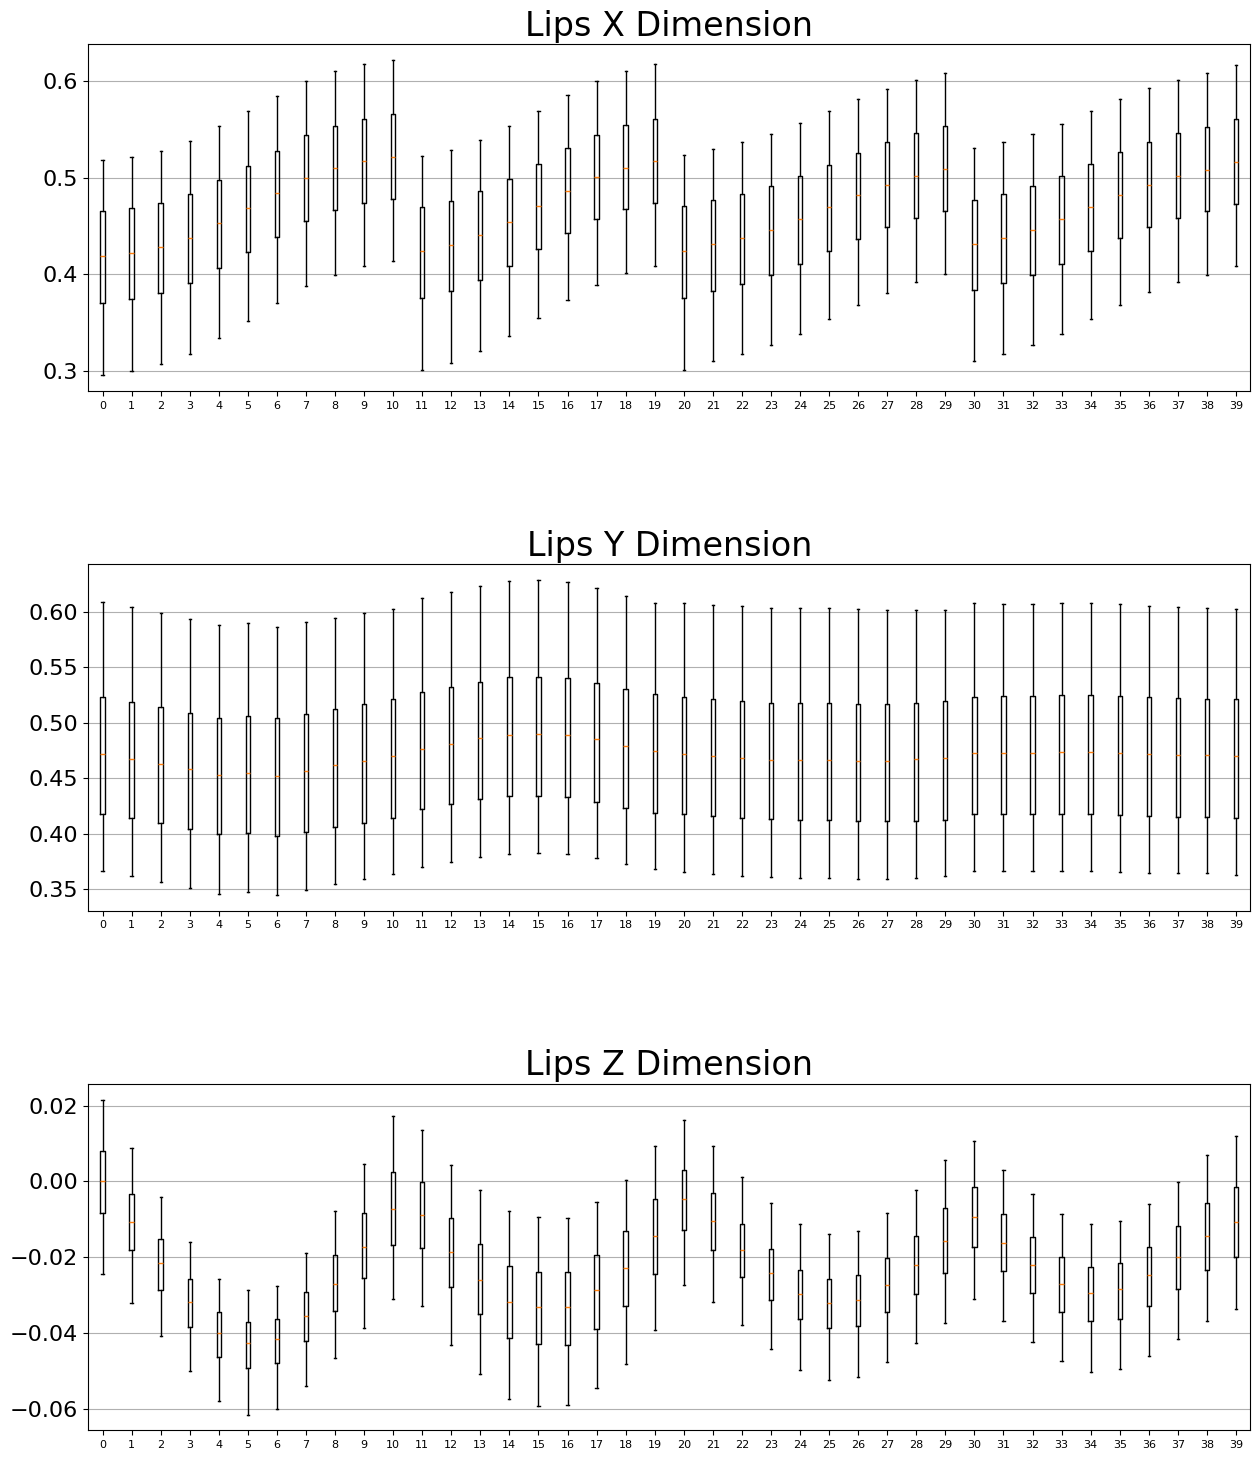

In [21]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

# Feature Statistics - Hands

In [31]:
# Verify Normalised to Left Hand Dominant
P_LEFT_HAND_MEASUREMENTS = (X_train[:,:,LEFT_HAND_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_HAND_MEASUREMENTS: {P_LEFT_HAND_MEASUREMENTS:.2f}%')

P_LEFT_HAND_MEASUREMENTS: 100.00%


  0%|          | 0/21 [00:00<?, ?it/s]

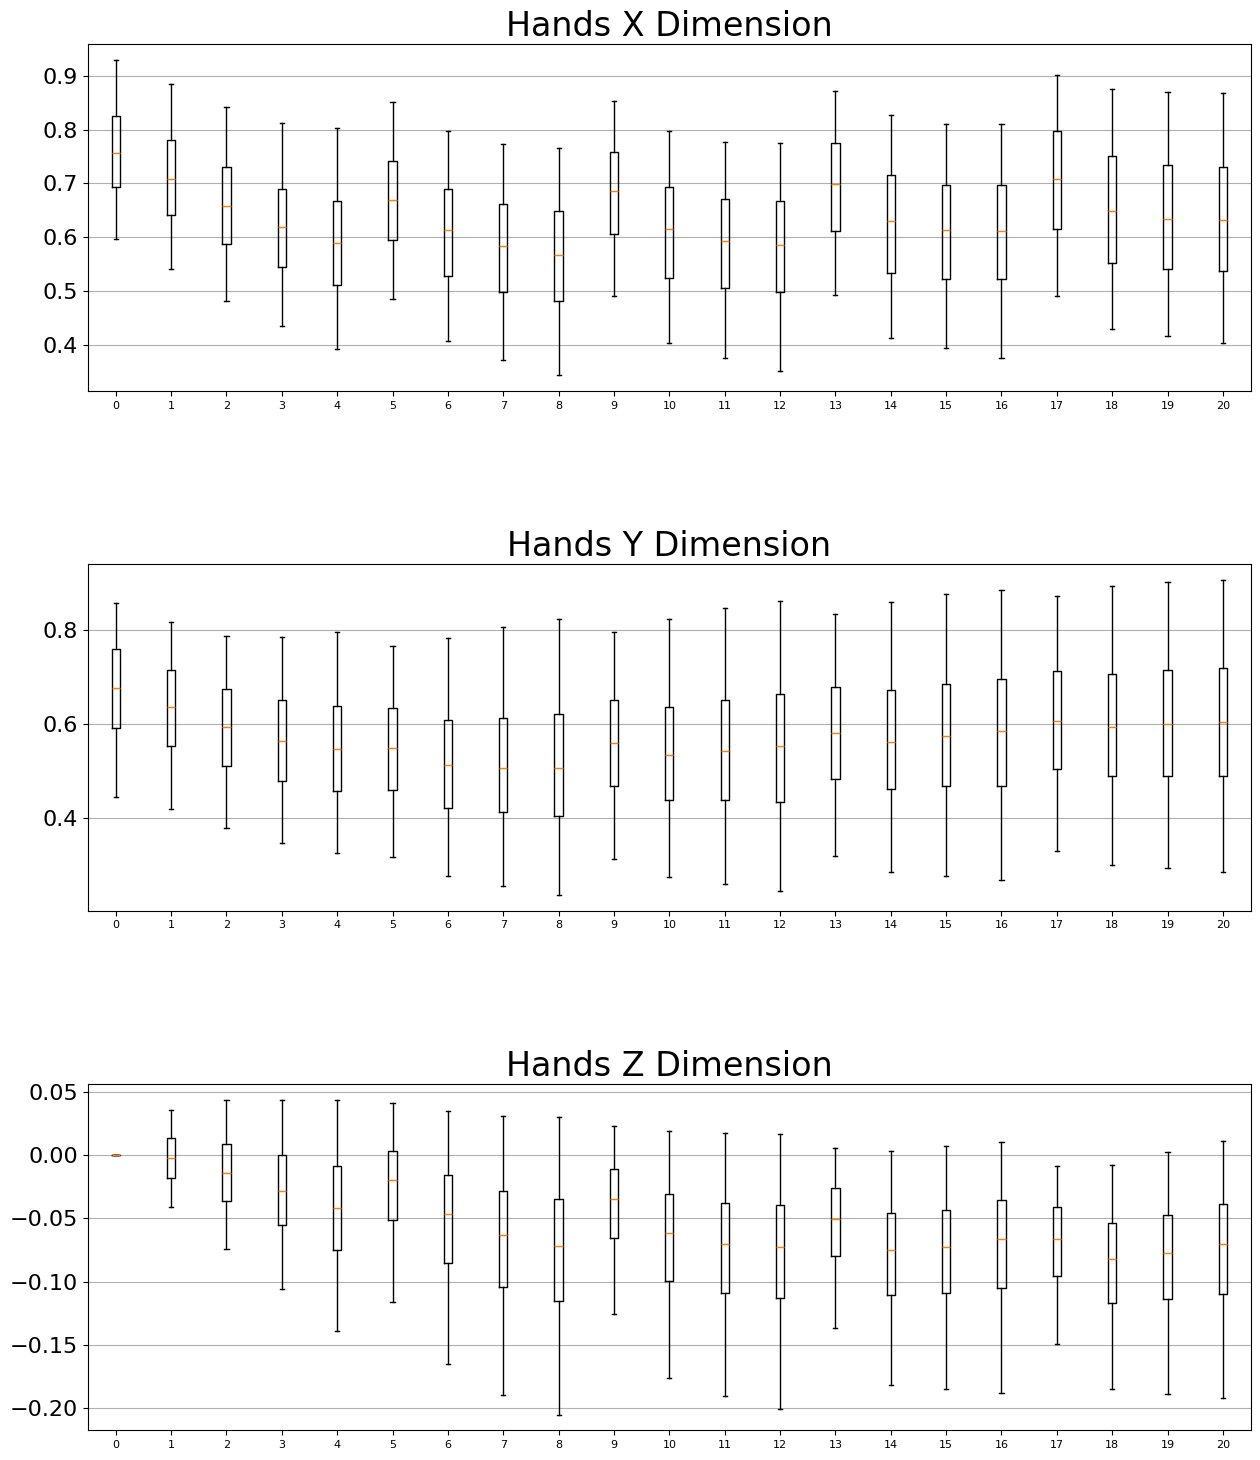

In [32]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T

    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

# Feature Statistics - Pose

In [33]:
# Percentage of Lips Measurements
P_POSE_MEASUREMENTS = (X_train[:,:,POSE_IDXS] != 0).sum() / X_train[:,:,POSE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_POSE_MEASUREMENTS: {P_POSE_MEASUREMENTS:.2f}%')

P_POSE_MEASUREMENTS: 100.00%


  0%|          | 0/5 [00:00<?, ?it/s]

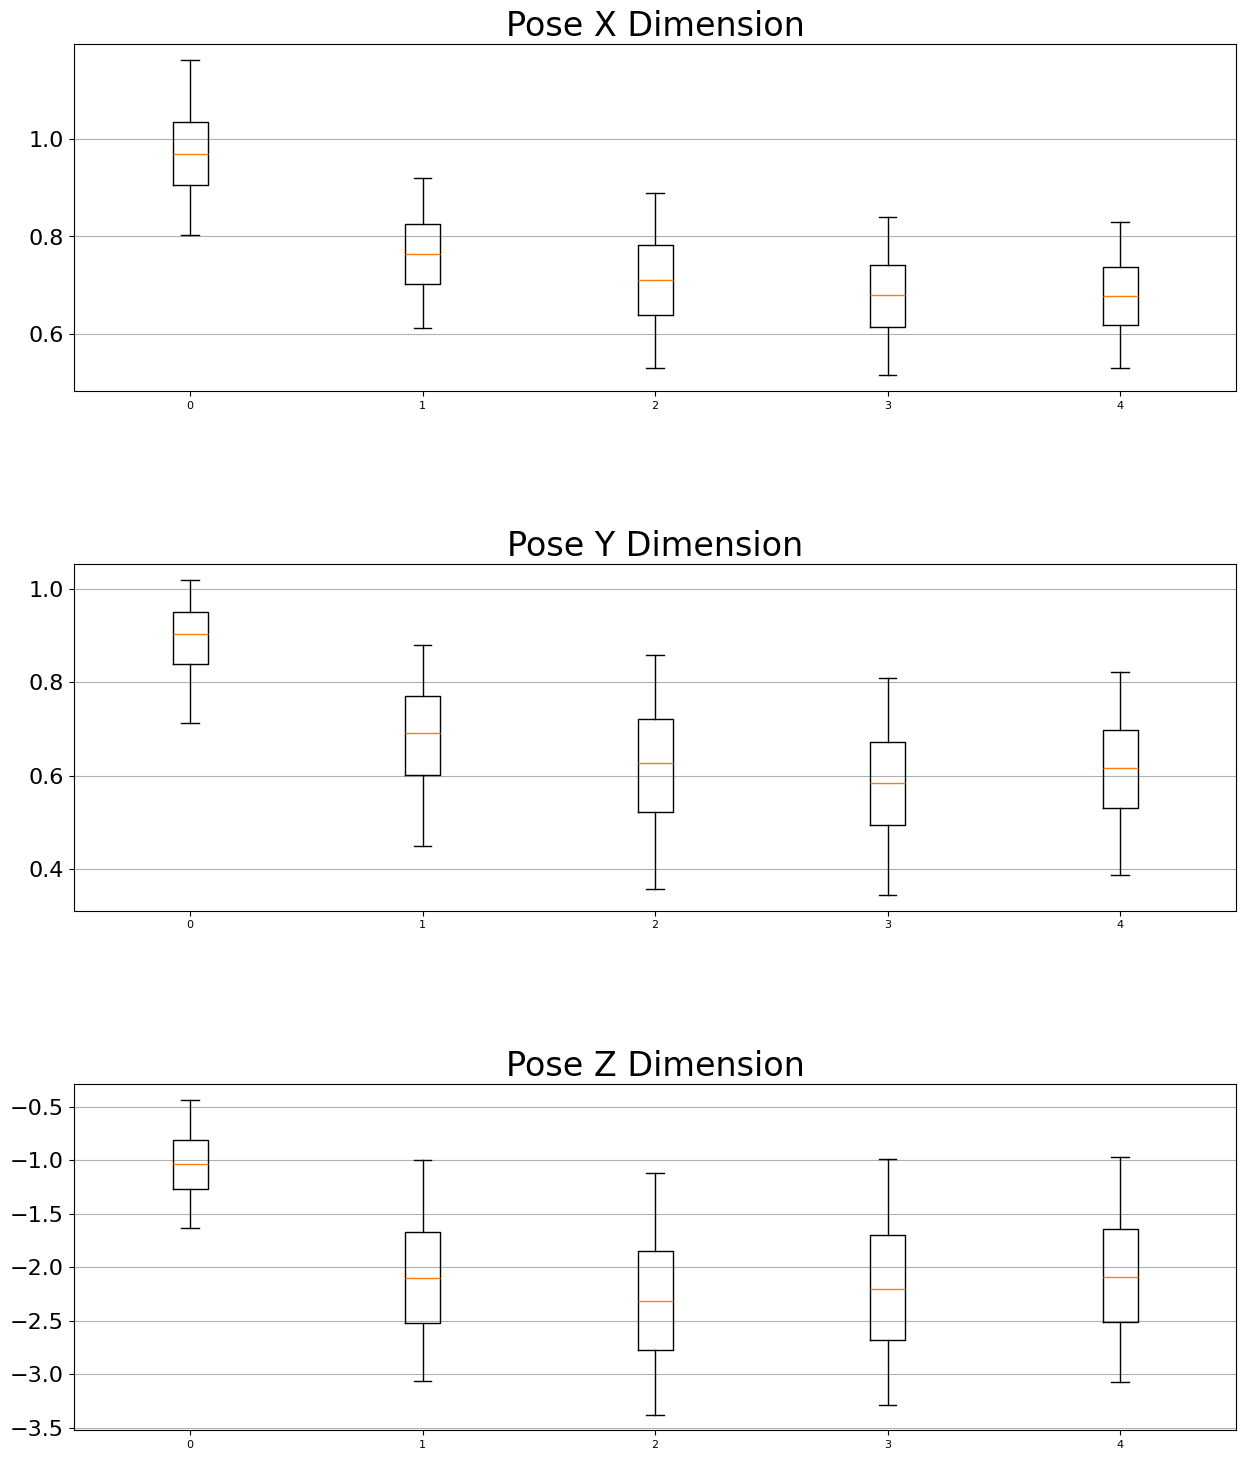

In [34]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

# Samples

In [35]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)

    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)

    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]

        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [36]:
dummy_dataset = get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (1000, 64, 66, 3), dtype: float32
non_empty_frame_idxs shape: (1000, 64), dtype: float32
y_batch shape: (1000,), dtype: int64


,Counts
0,4
171,4
158,4
159,4
160,4
...,...
88,4
89,4
90,4
91,4


# Model Config

In [37]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [38]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)

    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()

    def call(self,x, attention_mask):

        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))

        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [39]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks

    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))

    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)

        return x

# Landmark Embedding

In [40]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units

    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [41]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()

    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)

        return x

# Augmentation

In [42]:
# Not used, adds random X/y translation to input on samples level
class Augmentation(tf.keras.layers.Layer):
    def __init__(self, noise_std):
        super(Augmentation, self).__init__()
        self.noise_std = noise_std

    def add_noise(self, t):
        B = tf.shape(t)[0]
        return tf.where(
            t == 0.0,
            0.0,
            t + tf.random.normal([B,1,1,tf.shape(t)[3]], 0, self.noise_std),
        )

    def call(self, lips0, left_hand0, pose0, training=False):
        if training:
            # Lips
            lips0 = self.add_noise(lips0)
            # Left Hand
            left_hand0 = self.add_noise(left_hand0)
            # Pose
            pose0 = self.add_noise(pose0)

        return lips0, left_hand0, pose0

# Sparse Categorical Crossentropy With Label Smoothing

In [43]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

# Model

In [44]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )


    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )

    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])

    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)

    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)

    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)

    outputs = x

    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)

    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls

    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)

    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model


In [45]:
model = get_model()

In [46]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 non_empty_frame_idxs (Inpu  [(None, 64)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.math.not_equal_2 (TFOpL  (None, 64)                   0         ['non_empty_frame_idxs[0][0]']
 ambda)                                                                                           
                                                                                                  
 tf.cast_1 (TFOpLambda)      (None, 64)                   0         ['tf.math.not_equal_2[0][0]'] 
                                                                                              

In [104]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# No NaN Predictions

In [80]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    y_pred = model.predict_on_batch(X_batch).flatten()

    print(f'# NaN Values In Prediction: {np.isnan(y_pred).sum()}')

# NaN Values In Prediction: 0


# Weight Initialization

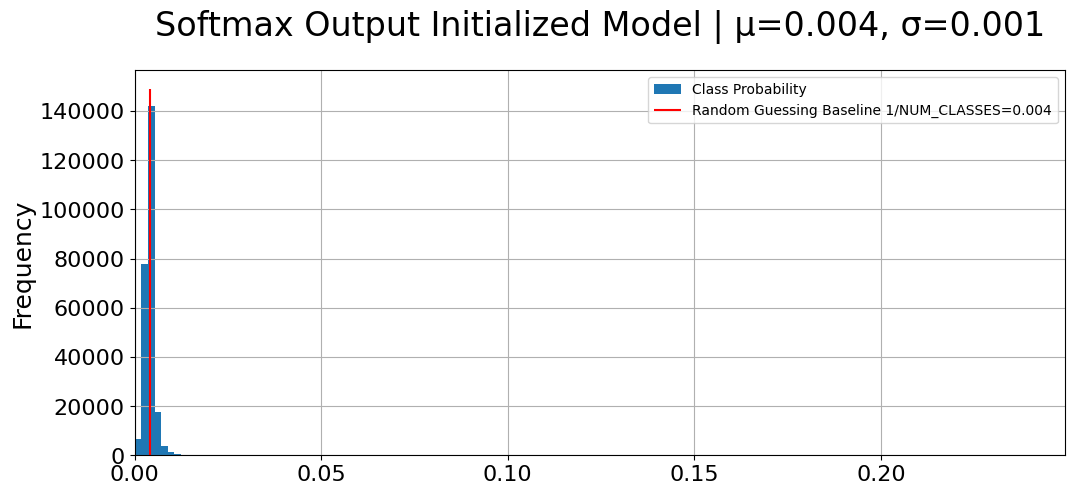

In [81]:
if not PREPROCESS_DATA and TRAIN_MODEL:
    plt.figure(figsize=(12,5))
    plt.title(f'Softmax Output Initialized Model | µ={y_pred.mean():.3f}, σ={y_pred.std():.3f}', pad=25)
    pd.Series(y_pred).plot(kind='hist', bins=128, label='Class Probability')
    plt.xlim(0, max(y_pred) * 1.1)
    plt.vlines([1 / NUM_CLASSES], 0, plt.ylim()[1], color='red', label=f'Random Guessing Baseline 1/NUM_CLASSES={1 / NUM_CLASSES:.3f}')
    plt.grid()
    plt.legend()
    plt.show()

# Learning Rate Scheduler

In [82]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):

    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

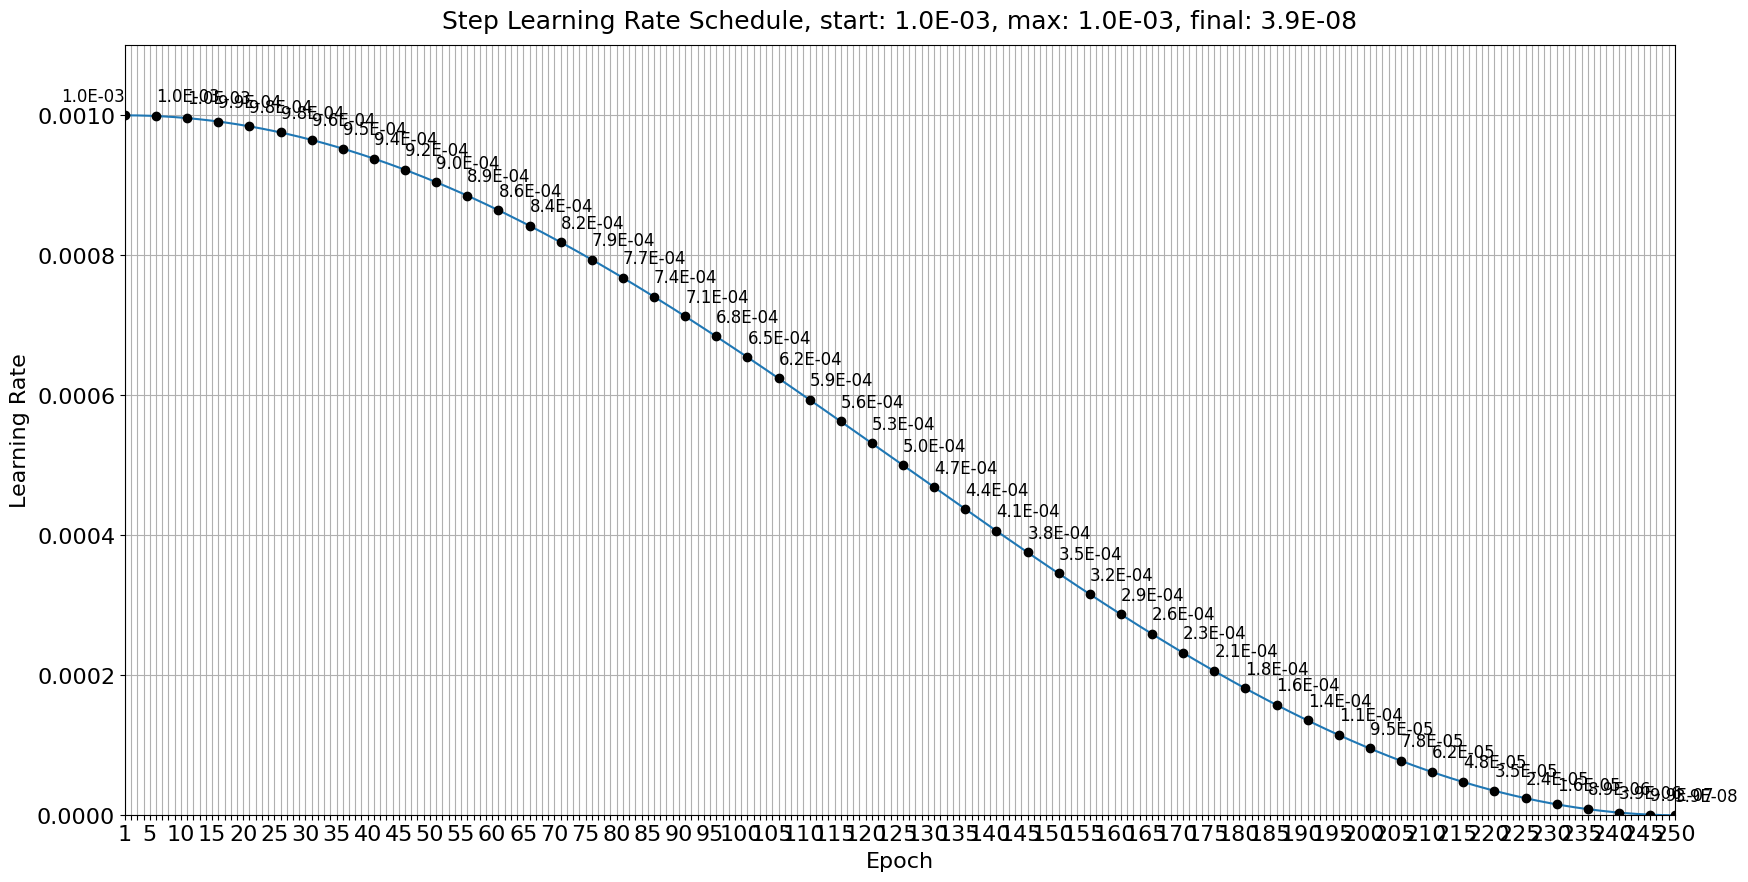

In [83]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Weight Decay Callback

In [109]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Performance Benchmark

In [110]:
%%timeit -n 100
if TRAIN_MODEL:
    # Verify model prediction is <<<100ms
    model.predict_on_batch({ 'frames': X_train[:1], 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TRAIN[:1] })
    pass

23.5 ms ± 4.65 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Training

In [111]:
if USE_VAL:
    # Verify Validation Dataset Covers All Signs
    print(f'# Unique Signs in Validation Set: {pd.Series(y_val).nunique()}')
    # Value Counts
    display(pd.Series(y_val).value_counts().to_frame('Count').iloc[[1,2,3,-3,-2,-1]])

# Evaluate Initialzied Model

In [112]:
# Sanity Check
if TRAIN_MODEL and USE_VAL:
    _ = model.evaluate(*validation_data, verbose=2)

In [47]:
model.load_weights('model (1).h5')

# Train

In [56]:
# if TRAIN_MODEL:
#     # Clear all models in GPU
#     tf.keras.backend.clear_session()

#     # Get new fresh model
#     model = get_model()

#     # Sanity Check
#     model.summary()

#     # Actual Training
#     history = model.fit(
#             x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
#             steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
#             epochs=N_EPOCHS,
#             # Only used for validation data since training data is a generator
#             batch_size=BATCH_SIZE,
#             validation_data=validation_data,
#             callbacks=[
#                 lr_callback,
#                 WeightDecayCallback(),
#             ],
#             verbose = VERBOSE,
#         )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 non_empty_frame_idxs (Inpu  [(None, 64)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.math.not_equal (TFOpLam  (None, 64)                   0         ['non_empty_frame_idxs[0][0]']
 bda)                                                                                             
                                                                                                  
 tf.cast (TFOpLambda)        (None, 64)                   0         ['tf.math.not_equal[0][0]']   
                                                                                              

In [57]:
# # Save Model Weights
# model.save_weights('model1.h5')
# model.save('model2.keras')
# model

In [119]:
# import numpy as np
# import cv2
# import pandas as pd
# import mediapipe as mp

# # Initialize an empty list to store landmarks data
# landmarks_data = []

# # Create an instance of the Holistic class
# holistic = mp.solutions.holistic.Holistic()

# # Provide the path to your video file
# video_path = 'BIRD.mp4'

# # Create a VideoCapture object
# cap = cv2.VideoCapture(video_path)

# frame = 0
# while cap.isOpened():
#     success, image = cap.read()
#     if image is None:
#         break


#     image.flags.writeable = False
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Use the process method of the Holistic instance
#     results = holistic.process(image)

#     # Process face landmarks
#     for idx in range(543):  # Assuming there are 543 landmarks
#         if results.face_landmarks and idx < len(results.face_landmarks.landmark):
#             landmark = results.face_landmarks.landmark[idx]
#             x, y, z = landmark.x, landmark.y, landmark.z
#         else:
#             x, y, z = np.nan, np.nan, np.nan  # Use NaN for missing landmarks

#         # Append the data to the list
#         landmarks_data.append([frame, f'frame{frame}_face_{idx}', 'face', idx, x, y, z])

#     # Similarly, process 'left_hand', 'pose', 'right_hand' landmarks

#     frame += 1

# # Convert the list to a DataFrame
# landmarks_data = pd.DataFrame(landmarks_data, columns=['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z'])

# # Save landmarks data to a CSV file
# landmarks_data.to_csv('landmarks_data.csv', index=False)


In [89]:
# filexyz1 = pd.read_csv('landmarks_data.csv')
# print(filexyz1)
# import pandas as pd



kocharr_1.to_parquet('hellodigi1.parquet')
# kocharr_2.to_parquet('hellodigi2.parquet')
# kocharr_3.to_parquet('hellodigi3.parquet')

In [98]:
def get_dataa(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    return data
lastpath = 'hellodigi1.parquet'

data1= get_dataa(lastpath)
# data2= get_dataa(mypath2)
# data3= get_dataa(mypath3)
X_preprocessed11, non_empty_frame_idxs11 = data1
print(X_preprocessed11.shape, non_empty_frame_idxs11.shape)

# X_preprocessed112, non_empty_frame_idxs112 = data2
# X_preprocessed113, non_empty_frame_idxs113 = data3


(64, 66, 3) (64,)
(<tf.Tensor: shape=(64, 66, 3), dtype=float32, numpy=
array([[[ 5.0886708e-01,  2.8658545e-01, -2.6793373e-03],
        [ 5.1008266e-01,  2.8380495e-01, -5.8965380e-03],
        [ 5.1298821e-01,  2.8039002e-01, -9.3771759e-03],
        ...,
        [ 5.8280212e-01,  1.0108919e+00, -6.2339085e-01],
        [ 5.5720937e-01,  9.9089891e-01, -6.5153140e-01],
        [ 5.5954415e-01,  9.6626079e-01, -5.5563325e-01]],

       [[ 5.0847703e-01,  2.8725055e-01, -2.3752649e-03],
        [ 5.0976712e-01,  2.8461128e-01, -5.6484030e-03],
        [ 5.1276731e-01,  2.8137466e-01, -9.1995625e-03],
        ...,
        [ 5.8280033e-01,  9.9304426e-01, -6.4241689e-01],
        [ 5.5633599e-01,  9.7518015e-01, -6.7182720e-01],
        [ 5.5850786e-01,  9.5019412e-01, -5.7505816e-01]],

       [[ 5.1039463e-01,  2.9103598e-01, -9.7435911e-04],
        [ 5.1160240e-01,  2.8861800e-01, -4.3435995e-03],
        [ 5.1448488e-01,  2.8566393e-01, -7.9293707e-03],
        ...,
        [ 5.861

In [158]:
# def get_myPred(video_path1):
#     %cd "C:\Users\prano\MP"
#     import cv2
#     import mediapipe as mp
#     from IPython.display import Image, display
#     import matplotlib.pyplot as plt
    
#     mp_drawing = mp.solutions.drawing_utils
#     mp_drawing_styles = mp.solutions.drawing_styles
#     mp_holistic = mp.solutions.holistic
    
#     # video_path2 = 'have(asl).mp4'
#     # video_path3 = 'BIRD.mp4'
    
#     # def transform(path , start_frame , end_frame , fps):
#     def transformM(path ):
#         frame_number = 0
#         frame = []
#         type_ = []
#         index = []
#         x = []
#         y = []
#         z = []
        
#         cap = cv2.VideoCapture(path)
#     #     cap.set(cv2.CAP_PROP_FPS, fps)
#         with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
#             while cap.isOpened():
#                 success, image = cap.read()
#                 if not success:
#                     break
#                 frame_number += 1
#                 image.flags.writeable = False
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                 results = holistic.process(image)
#                 #face
#                 if(results.face_landmarks is None):
#                     for i in range(468):
#                         frame.append(frame_number)
#                         type_.append("face")
#                         index.append(ind)
#                         x.append(None)
#                         y.append(None)
#                         z.append(None)
#                 else:
#                     for ind,val in enumerate(results.face_landmarks.landmark):
#                         frame.append(frame_number)
#                         type_.append("face")
#                         index.append(ind)
#                         x.append(val.x)
#                         y.append(val.y)
#                         z.append(val.z)
#                 #left hand
#                 if(results.left_hand_landmarks is None):
#                     for i in range(21):
#                         frame.append(frame_number)
#                         type_.append("left_hand")
#                         index.append(ind)
#                         x.append(None)
#                         y.append(None)
#                         z.append(None)
#                 else:
#                     for ind,val in enumerate(results.left_hand_landmarks.landmark):
#                         frame.append(frame_number)
#                         type_.append("left_hand")
#                         index.append(ind)
#                         x.append(val.x)
#                         y.append(val.y)
#                         z.append(val.z)
#                 #pose
#                 if(results.pose_landmarks is None):
#                     for i in range(33):
#                         frame.append(frame_number)
#                         type_.append("pose")
#                         index.append(ind)
#                         x.append(None)
#                         y.append(None)
#                         z.append(None)
#                 else:
#                     for ind,val in enumerate(results.pose_landmarks.landmark):
#                         frame.append(frame_number)
#                         type_.append("pose")
#                         index.append(ind)
#                         x.append(val.x)
#                         y.append(val.y)
#                         z.append(val.z)
#                 #right hand
#                 if(results.right_hand_landmarks is None):
#                     for i in range(21):
#                         frame.append(frame_number)
#                         type_.append("right_hand")
#                         index.append(ind)
#                         x.append(None)
#                         y.append(None)
#                         z.append(None)
#                 else:
#                     for ind,val in enumerate(results.right_hand_landmarks.landmark):
#                         frame.append(frame_number)
#                         type_.append("right_hand")
#                         index.append(ind)
#                         x.append(val.x)
#                         y.append(val.y)
#                         z.append(val.z)
                
#         return pd.DataFrame({
#             "frame" : frame,
#             "type"  : type_,
#             "landmark_index" : index,
#             "x" : x,
#             "y" : y,
#             "z" : z
#         })
        
#     kocharr_1= transformM(video_path )
#     kocharr_1.to_parquet('hellodigi1.parquet')
#     def get_dataa(file_path):
#         # Load Raw Data
#         data = load_relevant_data_subset(file_path)
#         # Process Data Using Tensorflow
#         data = preprocess_layer(data)
#         return data
#     lastpath = 'hellodigi1.parquet'
    
#     data1= get_dataa(lastpath)
#     # data2= get_dataa(mypath2)
#     # data3= get_dataa(mypath3)
#     X_preprocessed11, non_empty_frame_idxs11 = data1
#     print(X_preprocessed11.shape, non_empty_frame_idxs11.shape)
#     data_reshaped11 = tf.expand_dims(X_preprocessed11, axis=0)

#     data_reshaped11 = np.array(data_reshaped11)
#     non_empty_frame_idxs11 = np.array(non_empty_frame_idxs11)
    
#     data_reshaped_non_empty = non_empty_frame_idxs11.reshape((1, 64))
    
#     y_val_pred = model.predict({ 'frames': data_reshaped11 , 'non_empty_frame_idxs': data_reshaped_non_empty }, verbose=2).argmax(axis=1)
#     print(y_val_pred)
    
# videoo_path =input('enter video path') 
# get_myPred(videoo_path)     

enter video path 'CHOCOLATE.mp4'


C:\Users\prano\.conda\envs\condaenvlatest\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\prano\MP
(64, 66, 3) (64,)
1/1 - 0s - 34ms/epoch - 34ms/step
[174]


In [54]:
import cv2
import tkinter as tk
from PIL import Image, ImageTk
from IPython.display import Image as IPImage, display as ip_display
from gtts import gTTS
import os
import pygame
import random
import string
from io import BytesIO
import json
from tkinter import filedialog
def open_image_to_text():
    %cd image_captioning
    global tk
    global ImageTk
    global Image
    main_menu_window.destroy()
    class CameraApp:
        def __init__(self, window, window_title):
            self.window = window
            self.window.title(window_title)

            # Open the default camera (usually 0)
            self.cap = cv2.VideoCapture(0)
            if not self.cap.isOpened():
                print("Error: Could not open camera")
                return

            # Initialize GUI
            self.canvas = tk.Canvas(window, width=self.cap.get(cv2.CAP_PROP_FRAME_WIDTH), height=self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            self.canvas.pack()

            # Capture button
            self.btn_capture = tk.Button(window, text="Capture", width=10, command=self.capture)
            self.btn_capture.pack(anchor=tk.CENTER, expand=True)

            # Close button
            self.btn_close = tk.Button(window, text="Close", width=10, command=self.close_camera)
            self.btn_close.pack(anchor=tk.CENTER, expand=True)

            self.update()

            self.window.protocol("WM_DELETE_WINDOW", self.on_closing)
            self.window.mainloop()

        def capture(self):
            # Capture frame-by-frame
            ret, frame = self.cap.read()
            if not ret:
                print("Error: Failed to capture image")
                return

            cv2.imwrite("photo.jpg", frame)
            print("Photo saved as photo.jpg")

        def close_camera(self):
            # Release the camera
            self.cap.release()
            # Close the window
            self.window.destroy()

        def on_closing(self):
            # Release the camera
            self.cap.release()
            # Close the window
            self.root.destroy()
            # Display the captured image using IPython.display
            ip_display(IPImage("photo.jpg"))

        def update(self):
            # Get a frame from the camera
            ret, frame = self.cap.read()
            if ret:
                self.photo = ImageTk.PhotoImage(image=Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
                self.canvas.create_image(0, 0, image=self.photo, anchor=tk.NW)
            self.window.after(10, self.update)

    if __name__ == "__main__":
        root = tk.Toplevel()
        app = CameraApp(root, "Camera App")
    import torch
    from torchvision import transforms
    from PIL import Image
    import os
    import json
    from collections import defaultdict
    from tqdm import tqdm
    import pickle

    from model import EncoderCNN, DecoderRNN

    def load_image(image_path, transform):
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0)
        return image

    def post_process_caption(caption, vocab):
        # Convert indices to sentence using vocabulary
        sentence = [vocab.idx2word[idx] for idx in caption]
        # Join the words into a single string
        generated_sentence = ' '.join(sentence)
        return generated_sentence

    # Set the path to your test image
    test_image_path = "photo.jpg"

    # Set the paths to your trained model weights
    encoder_file = "D:/Study/College/MInor Project/New folder/image_captioning/encoder-3.pkl"
    decoder_file = "D:/Study/College/MInor Project/New folder/image_captioning/decoder-3.pkl"

    # Set the path to your vocabulary file (vocab.pkl)
    vocab_file = "C:/Users/prano/Untitled Folder/image_captioning/vocab.pkl"

    # Define the transformations for image preprocessing
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    # Load the vocabulary
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)

    # Initialize the encoder and decoder
    embed_size = 256  # dimensionality of image and word embeddings
    hidden_size = 512
    encoder = EncoderCNN(embed_size)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab))

    # Move models to CPU or GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder.to(device)
    decoder.to(device)

    # Load the trained weights
    encoder.load_state_dict(torch.load(encoder_file, map_location=device))
    decoder.load_state_dict(torch.load(decoder_file, map_location=device))

    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    # Preprocess the test image
    test_image = load_image(test_image_path, transform_test).to(device)

    # Perform inference
    with torch.no_grad():
        features = encoder(test_image).unsqueeze(1)
        output = decoder.sample(features)
    import tkinter as tk
    from PIL import Image, ImageTk
    from IPython.display import Image as IPImage, display as ip_display

    def display_photo_and_caption(photo_path, generated_caption):
        # Create a Tkinter window with 720p resolution
        window = tk.Toplevel()
        window.title("Photo and Caption Display")
        window.geometry("1280x720")  # Set window size to 720p resolution

        # Load the photo
        photo = Image.open(photo_path)
        photo = photo.resize((640, 480))
        photo_tk = ImageTk.PhotoImage(photo)

        # Display the photo
        photo_label = tk.Label(window, image=photo_tk)
        photo_label.place(relx=0.5, rely=0.5, anchor=tk.CENTER)

        # Display the generated caption with increased font size
        caption_label = tk.Label(window, text="Generated Caption: " + generated_caption, wraplength=600, font=("Helvetica", 16))
        caption_label.place(relx=0.5, rely=0.9, anchor=tk.CENTER)
            
        # Add a title label
        title_label = tk.Label(window, text="Image Recognition", font=("Helvetica", 20, "bold"))
        title_label.place(relx=0.5, rely=0.1, anchor=tk.CENTER)
        # Play audio button
        generate_and_play_audio(generated_caption)


        window.mainloop()


    if __name__ == "__main__":
        generated_caption = post_process_caption(output, vocab)
        print("Generated Caption:", generated_caption)
        caption_for_audio = generated_caption.replace("<start>", "").replace("<end>", "").strip()
        photo_path = "photo.jpg"
        display_photo_and_caption(photo_path, caption_for_audio)
        generate_audio(caption_for_audio)
        

        
def generate_audio(text):
    global random_filename
    tts = gTTS(text=text)
    random_filename = ''.join(random.choice(string.ascii_lowercase) for _ in range(10)) + ".mp3"
    tts.save(random_filename)

def generate_and_play_audio(text):   
    generate_audio(text)
    pygame.init()
    pygame.mixer.init()
    pygame.mixer.music.load(random_filename)
    pygame.mixer.music.play()
    time.sleep(get_audio_length(random_filename))
    pygame.mixer.music.stop()
    
def get_audio_length(file_path):
    audio = pygame.mixer.Sound(file_path)
    return audio.get_length()
        
def text_to_speech_window():
    # Create Tkinter window
    tts_window = tk.Toplevel()
    tts_window.title("Text to Speech")
    window_width = 400
    window_height = 200
    screen_width = tts_window.winfo_screenwidth()
    screen_height = tts_window.winfo_screenheight()
    x_position = (screen_width - window_width) // 2
    y_position = (screen_height - window_height) // 2
    tts_window.geometry(f"{window_width}x{window_height}+{x_position}+{y_position}")

    # Add entry widget for input text
    entry = tk.Entry(tts_window, width=50, font=("Helvetica", 12))
    entry.pack(pady=20)
    def generate_and_play_audio():
        text = entry.get()
        tts = gTTS(text=text, lang='en')
        random_filename = ''.join(random.choice(string.ascii_lowercase) for _ in range(10)) + ".mp3"
        tts.save(random_filename)
        pygame.mixer.init()
        pygame.mixer.music.load(random_filename)
        pygame.mixer.music.play()

    # Add button to convert text to speech
    convert_button = tk.Button(tts_window, text="Convert to Speech", command=generate_and_play_audio, font=("Helvetica", 15))
    convert_button.pack(pady=20)

    # Run the Tkinter event loop for the text-to-speech window
    tts_window.mainloop()

def sign_language_to_text_window():
    # Create Tkinter window
    slt_window = tk.Toplevel()
    slt_window.title("Sign Language to Text")

    # Set window size and position
    window_width = 400
    window_height = 200
    screen_width = slt_window.winfo_screenwidth()
    screen_height = slt_window.winfo_screenheight()
    x_position = (screen_width - window_width) // 2
    y_position = (screen_height - window_height) // 2
    slt_window.geometry(f"{window_width}x{window_height}+{x_position}+{y_position}")
    def browse_video():
        filename = filedialog.askopenfilename(initialdir="/", title="Select Video File", filetypes=(("Video files", "*.mp4 *.avi"), ("All files", "*.*")))
        video_path_entry.delete(0, tk.END)
        video_path_entry.insert(tk.END, filename)
    def process_video_path():
        video_path = video_path_entry.get()
        if video_path:
            result = get_myPred(video_path)
            result_label.config(text="Generated Text: "+answer)
            generate_and_play_audio(answer)

    video_path_label = tk.Label(slt_window, text="Select video file:", font=("Helvetica", 12))
    video_path_label.pack(pady=5)
    video_path_entry = tk.Entry(slt_window, width=50, font=("Helvetica", 12))
    video_path_entry.pack(pady=5)
    browse_button = tk.Button(slt_window, text="Browse", command=browse_video, font=("Helvetica", 12))
    browse_button.pack(pady=5)
    process_button = tk.Button(slt_window, text="Translate", command=process_video_path, font=("Helvetica", 12))
    process_button.pack(pady=5)
    result_label = tk.Label(slt_window, text="", font=("Helvetica", 12))
    result_label.pack(pady=5)
    slt_window.mainloop()
def get_myPred(video_path1):
        %cd "C:\Users\prano\MP"
        import cv2
        import mediapipe as mp
        from IPython.display import Image, display
        import matplotlib.pyplot as plt
        global y_val_pred
        global answer
        global aud
        video_path = video_path1
        mp_drawing = mp.solutions.drawing_utils
        mp_drawing_styles = mp.solutions.drawing_styles
        mp_holistic = mp.solutions.holistic
        
        # video_path2 = 'have(asl).mp4'
        # video_path3 = 'BIRD.mp4'
        
        # def transform(path , start_frame , end_frame , fps):
        def transformM(path):
            frame_number = 0
            frame = []
            type_ = []
            index = []
            x = []
            y = []
            z = []
            
            cap = cv2.VideoCapture(path)
        #     cap.set(cv2.CAP_PROP_FPS, fps)
            with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
                while cap.isOpened():
                    success, image = cap.read()
                    if not success:
                        break
                    frame_number += 1
                    image.flags.writeable = False
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    results = holistic.process(image)
                    #face
                    if(results.face_landmarks is None):
                        for i in range(468):
                            frame.append(frame_number)
                            type_.append("face")
                            index.append(ind)
                            x.append(None)
                            y.append(None)
                            z.append(None)
                    else:
                        for ind,val in enumerate(results.face_landmarks.landmark):
                            frame.append(frame_number)
                            type_.append("face")
                            index.append(ind)
                            x.append(val.x)
                            y.append(val.y)
                            z.append(val.z)
                    #left hand
                    if(results.left_hand_landmarks is None):
                        for i in range(21):
                            frame.append(frame_number)
                            type_.append("left_hand")
                            index.append(ind)
                            x.append(None)
                            y.append(None)
                            z.append(None)
                    else:
                        for ind,val in enumerate(results.left_hand_landmarks.landmark):
                            frame.append(frame_number)
                            type_.append("left_hand")
                            index.append(ind)
                            x.append(val.x)
                            y.append(val.y)
                            z.append(val.z)
                    #pose
                    if(results.pose_landmarks is None):
                        for i in range(33):
                            frame.append(frame_number)
                            type_.append("pose")
                            index.append(ind)
                            x.append(None)
                            y.append(None)
                            z.append(None)
                    else:
                        for ind,val in enumerate(results.pose_landmarks.landmark):
                            frame.append(frame_number)
                            type_.append("pose")
                            index.append(ind)
                            x.append(val.x)
                            y.append(val.y)
                            z.append(val.z)
                    #right hand
                    if(results.right_hand_landmarks is None):
                        for i in range(21):
                            frame.append(frame_number)
                            type_.append("right_hand")
                            index.append(ind)
                            x.append(None)
                            y.append(None)
                            z.append(None)
                    else:
                        for ind,val in enumerate(results.right_hand_landmarks.landmark):
                            frame.append(frame_number)
                            type_.append("right_hand")
                            index.append(ind)
                            x.append(val.x)
                            y.append(val.y)
                            z.append(val.z)
                    
            return pd.DataFrame({
                "frame" : frame,
                "type"  : type_,
                "landmark_index" : index,
                "x" : x,
                "y" : y,
                "z" : z
            })
            
        kocharr_1= transformM(video_path)
        kocharr_1.to_parquet('hellodigi1.parquet')
        def get_dataa(file_path):
            # Load Raw Data
            data = load_relevant_data_subset(file_path)
            # Process Data Using Tensorflow
            data = preprocess_layer(data)
            return data
        lastpath = 'hellodigi1.parquet'
        
        data1= get_dataa(lastpath)
        # data2= get_dataa(mypath2)
        # data3= get_dataa(mypath3)
        X_preprocessed11, non_empty_frame_idxs11 = data1
        print(X_preprocessed11.shape, non_empty_frame_idxs11.shape)
        data_reshaped11 = tf.expand_dims(X_preprocessed11, axis=0)
    
        data_reshaped11 = np.array(data_reshaped11)
        non_empty_frame_idxs11 = np.array(non_empty_frame_idxs11)
        
        data_reshaped_non_empty = non_empty_frame_idxs11.reshape((1, 64))
        
        y_val_pred = model.predict({ 'frames': data_reshaped11 , 'non_empty_frame_idxs': data_reshaped_non_empty }, verbose=2).argmax(axis=1)
        print(y_val_pred)
        with open('sign_to_prediction_index_map.json', 'r') as file:
            data = json.load(file)
        target_value = y_val_pred
        keys = []
        for key, value in data.items():
            if value == target_value:
                keys.append(key)
        answer = keys[0]
        aud = generate_audio(answer)
        return answer, aud
        
    
# Create the main menu window
def create_main_menu():
    global main_menu_window
    # Create Tkinter window
    main_menu_window = tk.Tk()
    main_menu_window.title("Main Menu")

    # Set window size and position
    screen_width = main_menu_window.winfo_screenwidth()
    screen_height = main_menu_window.winfo_screenheight()
    window_width = int(screen_width * 0.5)
    window_height = int(screen_height * 0.5)
    x_position = (screen_width - window_width) // 2
    y_position = (screen_height - window_height) // 2
    main_menu_window.geometry(f"{window_width}x{window_height}+{x_position}+{y_position}")
    title_label = tk.Label(main_menu_window, text="AI Powered Assistive Technology for Accesibility", font=("Helvetica", 20, "bold"))
    title_label.pack(pady=20)
    
    image_to_text_button = tk.Button(main_menu_window, text="Image to Text", command=open_image_to_text, width=20, height=2, font=("Helvetica", 10))
    image_to_text_button.pack(pady=(20))

    sign_language_to_text_button = tk.Button(main_menu_window, text="Sign Language to Text", command = sign_language_to_text_window,  width=20, height=2, font=("Helvetica", 10))
    sign_language_to_text_button.pack(pady=20)

    text_to_speech_button = tk.Button(main_menu_window, text="Text to Speech",  command=text_to_speech_window, width=20, height=2, font=("Helvetica", 10))
    text_to_speech_button.pack(pady=20)

    title_label = tk.Label(main_menu_window, text="By Pranoor & Prerit", font=("Helvetica", 18, "italic"))
    title_label.pack(pady=20)
    # Run the Tkinter event loop
    main_menu_window.mainloop()

# Call the function to create the main menu window
create_main_menu()

C:\Users\prano\.conda\envs\condaenvlatest\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\prano\MP
(64, 66, 3) (64,)
1/1 - 0s - 37ms/epoch - 37ms/step
[101]


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\prano\.conda\envs\condaenvlatest\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\prano\AppData\Local\Temp\ipykernel_17912\4188740462.py", line 267, in process_video_path
    generate_and_play_audio(answer)
  File "C:\Users\prano\AppData\Local\Temp\ipykernel_17912\4188740462.py", line 207, in generate_and_play_audio
    time.sleep(get_audio_length(random_filename))
NameError: name 'time' is not defined


In [110]:

videoo_path =input('enter video path')
pred_last= get_myPred(videoo_path)
print(pred_last)


enter video path 'CHOCOLATE.mp4'


(64, 66, 3) (64,)
1/1 - 0s - 43ms/epoch - 43ms/step
[181]


In [ ]:
# import numpy as np

# # Initialize an empty list to hold images
# images = []

# # For each unique frame in the data
# for frame in df['frame'].unique():
#     # Create a blank image
#     image = np.zeros((64, 66, 3))
    
#     # Get the data for this frame
#     frame_data = df[df['frame'] == frame]
    
#     # For each landmark in this frame
#     for idx, row in frame_data.iterrows():
#         # Draw the landmark on the image
#         # Note: You'll need to scale the x and y coordinates to fit the 64x66 size
#         x = int(row['x'] * 64)
#         y = int(row['y'] * 66)
#         x = min(int(row['x'] * 64), 63)
#         y = min(int(row['y'] * 66), 65)

#         image[x, y] = [row['x'], row['y'], row['z']]
    
#     # Add the image to the list of images
#     images.append(image)

# # Convert the list of images to a numpy array
# x_test = np.array(images)

# # Initialize an empty list to hold the indices of non-empty frames
# non_empty_frame_idxs_test = []

# # For each frame in x_test
# for idx, frame in enumerate(x_test):
#     # If the frame is not empty (assuming that 'empty' means all zeros)
#     if not np.all(frame == 0):
#         # Add the index to the list
#         non_empty_frame_idxs_test.append(idx)

# # Convert the list to a numpy array
# NON_EMPTY_FRAME_IDXS_TEST = np.array(non_empty_frame_idxs_test)
# # Assuming NON_EMPTY_FRAME_IDXS_TEST is prepared similarly to NON_EMPTY_FRAME_IDXS_VAL
# y_test_pred = model.predict({ 'frames': x_test, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST }, verbose=2).argmax(axis=1)


In [ ]:
print(model.predict(x_test))

In [ ]:
y_val_pred = model.predict({ 'frames': X_val.npy, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
# if USE_VAL:
#     # Validation Predictions
#     y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
#     # Label
#     labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]


# Landmark Attention Weights

In [ ]:
# Landmark Weights
for w in model.get_layer('embedding').weights:
    if 'landmark_weights' in w.name:
        weights = scipy.special.softmax(w)

landmarks = ['lips_embedding', 'left_hand_embedding', 'pose_embedding']

for w, lm in zip(weights, landmarks):
    print(f'{lm} weight: {(w*100):.1f}%')

# Classification Report

In [ ]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [ ]:
if USE_VAL:
    print_classification_report()

# Training History

In [ ]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))

    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 50:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)

    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)

    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)